<a href="https://colab.research.google.com/github/bbarthougatica/ChmInf/blob/Regression/GNN_Lipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Networks (GNN) for Lipo dataset

Molecular structures are naturally represented as graphs, where atoms correspond to nodes and chemical bonds correspond to edges. Traditional machine learning models, such as random forests or multilayer perceptrons, require fixed-size feature vectors as input, which often necessitates handcrafted molecular descriptors or fingerprints. While these approaches can capture certain structural properties, they typically fail to fully exploit the topological and relational information inherent in molecular graphs.

To address this limitation, a Graph Neural Network (GNN) was employed. GNNs are a class of neural networks specifically designed to operate directly on graph-structured data. They use a message passing mechanism, where each node iteratively exchanges information with its neighboring nodes and updates its internal representation based on the received “messages.” Through multiple layers of message passing, the network aggregates both local (neighboring atom interactions) and global (molecular structure) information to build expressive representations of molecules.

In this project, the GNN model was implemented using the Message Passing Neural Network (MPNN) framework proposed in the paper “Neural Message Passing for Quantum Chemistry” (Gilmer et al., 2017). This architecture allows the model to learn continuous, data-driven representations of molecular graphs without relying on handcrafted descriptors. The PyTorch Geometric (PyG) library was used for implementation, leveraging its built-in NNConv class, which encapsulates the key stages of message passing — message computation, aggregation, and node update — within a single layer abstraction. A subsequent readout phase aggregates node-level embeddings to produce a molecule-level representation, which is then used to predict the target property, in this case, lipophilicity (logD).

By using a GNN, the model can more effectively capture the structural dependencies and chemical context within molecules, leading to potentially more accurate and generalizable predictions compared to traditional descriptor-based methods.

In [ ]:
# Install all libraries
# CoLab has already preinstalled Pytorch for you
! pip install pytorch-lightning wandb rdkit ogb
# install PyG
! pip install torch_geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.3 MB/s eta 0:00:00


Set a random seed to ensure repeatability of experiments

In [ ]:
import random
import numpy as np
import torch

# Random Seeds and Reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)

## Graph Neural Network

A [graph neural network (GNN)](https://en.wikipedia.org/wiki/Graph_neural_network) is a class of artificial neural networks for processing data that can be represented as graphs. GNNs rely on [message passing methods](https://arxiv.org/abs/1704.01212), which means that nodes exchange information with the neighbors, and send "messages" to each other. Generally, GNNs operate in two phases: a **message passing** phase, which transmits information across the molecule to build a neural representation of the molecule, and a **readout** phase, which uses the final representation of the molecule to make predictions about the properties of interest.

Here, we will define a GNN model using message passing neural network (MPNN) according to paper ["Neural Message Passing for Quantum Chemistry"](https://arxiv.org/abs/1704.01212). We just use [NNConv](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.NNConv.html#torch_geometric.nn.conv.NNConv) class to create message passing layers of our models (the various steps outlined in the lecture, i.e., 'send messages' + 'message aggregation' + 'node update' all happen under the hood inside this class). The [torch_geometric.nn](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html) module of PyG contains many different types of layers for message passing and readout, which can help us define GNN models more conveniently.

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import GRU
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, MLP, global_add_pool
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder


class MPNN(pl.LightningModule):
    def __init__(self, hidden_dim, out_dim,
                 train_data, valid_data, test_data,
                 std, batch_size=32, lr=1e-3):
        super().__init__()
        self.std = std  # std of data's target
        self.train_data = train_data
        self.valid_data = valid_data
        self.test_data = test_data
        self.batch_size = batch_size
        self.lr = lr
        # Initial layers
        self.atom_emb = AtomEncoder(emb_dim=hidden_dim)
        self.bond_emb = BondEncoder(emb_dim=hidden_dim)
        # Message passing layers
        nn = MLP([hidden_dim, hidden_dim*2, hidden_dim*hidden_dim])
        self.conv = NNConv(hidden_dim, hidden_dim, nn, aggr='mean')
        self.gru = GRU(hidden_dim, hidden_dim)
        # Readout layers
        self.mlp = MLP([hidden_dim, int(hidden_dim/2), out_dim])
        # To compute r2
        self.test_preds = []
        self.test_targets = []

    def forward(self, data, mode="train"):

        # Initialization
        x = self.atom_emb(data.x)
        h = x.unsqueeze(0)
        edge_attr = self.bond_emb(data.edge_attr)

        # Message passing
        for i in range(3):
            m = F.relu(self.conv(x, data.edge_index, edge_attr))  # send message and aggregation
            x, h = self.gru(m.unsqueeze(0), h)  # node update
            x = x.squeeze(0)

        # Readout
        x = global_add_pool(x, data.batch)
        x = self.mlp(x)

        return x.view(-1)

    def training_step(self, batch, batch_idx):
        # Here we define the train loop.
        out = self.forward(batch, mode="train")
        loss = F.mse_loss(out, batch.y)
        self.log("Train loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # Define validation step. At the end of every epoch, this will be executed
        out = self.forward(batch, mode="valid")
        loss = F.mse_loss(out * self.std, batch.y * self.std)  # report MSE
        self.log("Valid MSE", loss)

    def test_step(self, batch, batch_idx):
        # What to do in test
        # We've modified this to also be able to save predictions to later compute R2
        out = self.forward(batch, mode="test")
        self.test_preds.append(out.detach())
        self.test_targets.append(batch.y.detach())
        loss = F.mse_loss(out * self.std, batch.y * self.std)  # report MSE
        self.log("Test MSE", loss)

    def configure_optimizers(self):
        # Here we configure the optimization algorithm.
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.lr
        )
        return optimizer

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_data, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False)

Here, we can use [InMemoryDataset]() class in PyG to create the graph dataset of Lipo conveniently.

In [ ]:
from tqdm import tqdm
import pandas as pd
import torch
from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
)
from ogb.utils import smiles2graph


class LipoGraphData(InMemoryDataset):
    """The Lipo graph dataset using PyG
    """
    # Lipo dataset download link
    raw_url = 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/Lipophilicity.csv'

    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def raw_file_names(self):
        return ['Lipophilicity.csv']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        print('Downloading Lipo dataset...')
        file_path = download_url(self.raw_url, self.raw_dir)

    def process(self):
        # load raw data from a csv file
        df = pd.read_csv(self.raw_paths[0])
        smiles = df['smiles'].values.tolist()
        target = df['exp'].values.tolist()

        # Convert SMILES into graph data
        print('Converting SMILES strings into graphs...')
        data_list = []
        for i, smi in enumerate(tqdm(smiles)):

            # get graph data from SMILES
            graph = smiles2graph(smi)

            # convert to tensor and pyg data
            x = torch.tensor(graph['node_feat'], dtype=torch.long)
            edge_index = torch.tensor(graph['edge_index'], dtype=torch.long)
            edge_attr = torch.tensor(graph['edge_feat'], dtype=torch.long)
            y = torch.tensor([target[i]], dtype=torch.float)
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
            data_list.append(data)

        # save data
        torch.save(self.collate(data_list), self.processed_paths[0])

Create, normalize and split Lipo graph dataset.

In [ ]:
from typing import Optional, Tuple
import numpy as np
from torch_geometric.data.dataset import Dataset


class RandomSplitter(object):
    """Class for doing random data splits."""

    def split(
        self,
        dataset: Dataset,
        frac_train: float = 0.7,
        frac_valid: float = 0.1,
        frac_test: float = 0.2,
        seed: Optional[int] = None,
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Splits internal compounds randomly into train/validation/test.

        Parameters
        ----------
        dataset: Dataset
          Dataset to be split.
        seed: int, optional (default None)
          Random seed to use.
        frac_train: float, optional (default 0.8)
          The fraction of data to be used for the training split.
        frac_valid: float, optional (default 0.1)
          The fraction of data to be used for the validation split.
        frac_test: float, optional (default 0.1)
          The fraction of data to be used for the test split.
        seed: int, optional (default None)
          Random seed to use.

        Returns
        -------
        Tuple[np.ndarray, np.ndarray, np.ndarray]
          A tuple of train indices, valid indices, and test indices.
          Each indices is a numpy array.
        """
        np.testing.assert_almost_equal(frac_train + frac_valid + frac_test, 1.0)
        if seed is not None:
            np.random.seed(seed)
        num_datapoints = len(dataset)
        train_cutoff = int(frac_train * num_datapoints)
        valid_cutoff = int((frac_train + frac_valid) * num_datapoints)
        shuffled = np.random.permutation(range(num_datapoints))
        return (
            shuffled[:train_cutoff],
            shuffled[train_cutoff:valid_cutoff],
            shuffled[valid_cutoff:],
        )

In [ ]:
# create dataset
dataset = LipoGraphData('./lipo_pyg').shuffle()

# Normalize target to mean = 0 and std = 1.
mean = dataset.data.y.mean()
std = dataset.data.y.std()
dataset.data.y = (dataset.data.y - mean) / std
mean, std = mean.item(), std.item()

# split data
splitter = RandomSplitter()
train_idx, valid_idx, test_idx = splitter.split(dataset, frac_train=0.7, frac_valid=0.1, frac_test=0.2)
train_dataset = dataset[train_idx]
valid_dataset = dataset[valid_idx]
test_dataset = dataset[test_idx]

Processing...


Converting SMILES strings into graphs...


100%|██████████| 4200/4200 [00:04<00:00, 872.70it/s]
Done!
/tmp/ipython-input-3833660770.py:5: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  mean = dataset.data.y.mean()
/tmp/ipython-input-3833660770.py:6: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. If you are absolutely certain what you are doing, access the internal storage via 

In [7]:
# Here we create an instance of our GNN.
# Play around with the hyperparameters!
gnn_model = MPNN(
    hidden_dim=64,
    out_dim=1,
    std=std,
    train_data=train_dataset,
    valid_data=valid_dataset,
    test_data=test_dataset,
    lr=0.001,
    batch_size=32
)

trainer = pl.Trainer(max_epochs = 60)

trainer.fit(model=gnn_model)

# Now run test
results = trainer.test(ckpt_path="best")

# Test RMSE
test_mse = results[0]["Test MSE"]
test_rmse = test_mse ** 0.5
print(f"\nMPNN model performance: RMSE on test set = {test_rmse:.4f}.\n")

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type        | Params | Mode 
-------------------------------------------------
0 | atom_emb | AtomEncoder | 11.1 K | train
1 | bond_emb | BondEncoder | 832    | train
2 | conv     | NNConv      | 541 K  | train
3 | gru      | GRU         | 25.0 K | train
4 | mlp      | MLP         | 2.2 K  | train
-------------------------------------------------
580 K     Trainable params
0         Non-trainable params
580 K     Total params
2.321     Total est

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 874. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 769. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 927. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 953. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 840. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 783. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=60` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=59-step=5520.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_0/checkpoints/epoch=59-step=5520.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 862. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 852. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 870. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 855. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Test MSE          │    0.36447131633758545    │
└───────────────────────────┴───────────────────────────┘


MPNN model performance: RMSE on test set = 0.6037.



In [8]:
from sklearn.metrics import r2_score
#To compute R2
y_true = torch.cat(gnn_model.test_targets).numpy()
y_pred = torch.cat(gnn_model.test_preds).numpy()
r2 = r2_score(y_true, y_pred)
print(f"MPNN Test R² = {r2:.4f}")

MPNN Test R² = 0.7384


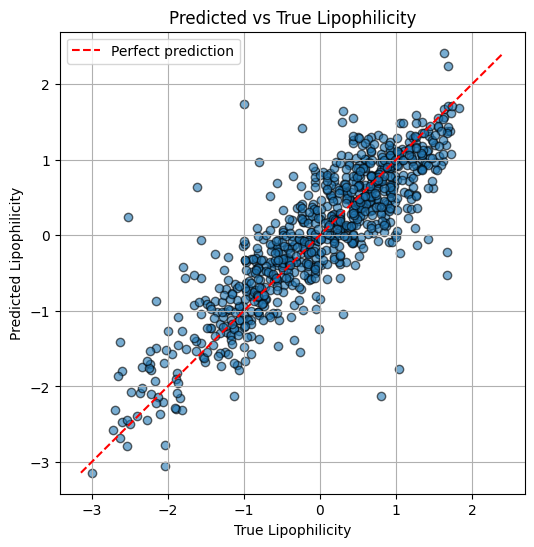

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k')

# Plot the diagonal line y = x
min_val = min(np.min(y_true), np.min(y_pred))
max_val = max(np.max(y_true), np.max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction')

# Labels and title
plt.xlabel('True Lipophilicity')
plt.ylabel('Predicted Lipophilicity')
plt.title('Predicted vs True Lipophilicity')
plt.legend()
plt.grid(True)
plt.show()

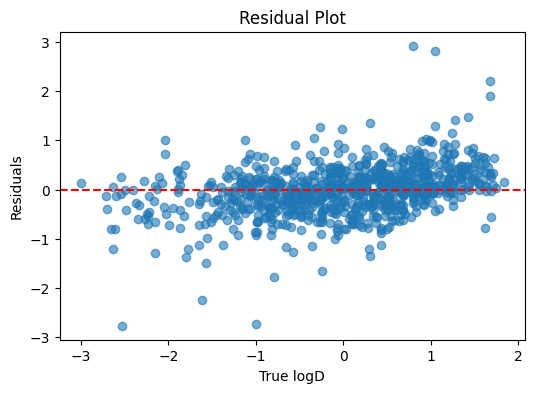

In [12]:
residuals = y_true - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_true, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('True logD')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()